[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data for MSFT...
Fetching data for AAPL...

Unit Root Test (ADF) for MSFT Prices:
ADF Statistic: -1.3379
p-value: 0.6117
Critical Values: {'1%': -3.4354, '5%': -2.8638, '10%': -2.5679}
MSFT Prices likely has a unit root (non-stationary).

Unit Root Test (ADF) for AAPL Prices:
ADF Statistic: -1.1759
p-value: 0.6839
Critical Values: {'1%': -3.4353, '5%': -2.8637, '10%': -2.5679}
AAPL Prices likely has a unit root (non-stationary).



Unit Root Test (ADF) for MSFT Returns:
ADF Statistic: -11.5849
p-value: 0.0000
Critical Values: {'1%': -3.4354, '5%': -2.8638, '10%': -2.5679}
MSFT Returns does not have a unit root (stationary).

Unit Root Test (ADF) for AAPL Returns:
ADF Statistic: -11.6024
p-value: 0.0000
Critical Values: {'1%': -3.4354, '5%': -2.8638, '10%': -2.5679}
AAPL Returns does not have a unit root (stationary).

ARMA(1,1) Model Summary for MSFT Returns:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.121      0.034    7.14e-05       0.002
ar.L1         -0.1215      0.089     -1.360      0.174      -0.297       0.054
ma.L1         -0.0579      0.096     -0.606      0.545      -0.245       0.129
sigma2         0.0003    8.4e-06     41.582      0.000       0.000       0.000

ARMA(1,1) Model Summary for AAPL Returns:
                 coef    std err          z   

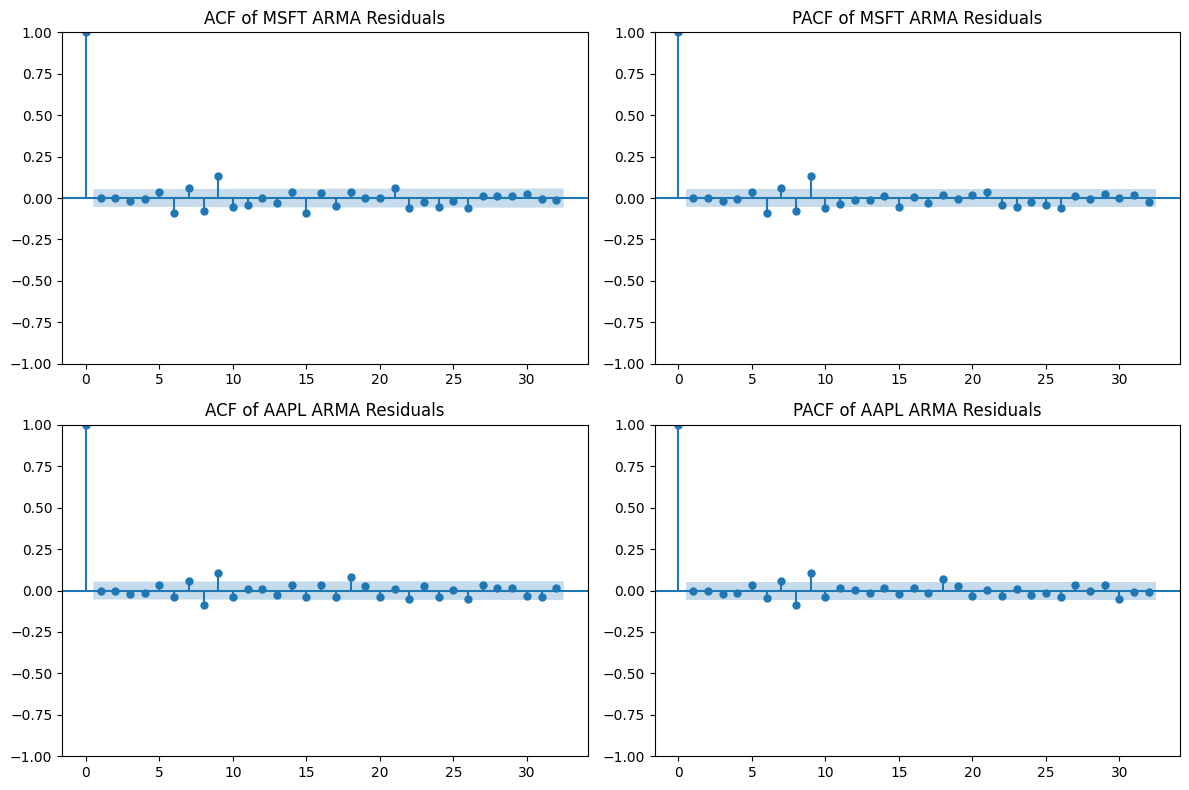


Cointegration Test (Engle-Granger) between MSFT and AAPL Prices:
Cointegration Test Statistic: -2.0733
p-value: 0.4903
Critical Values: {'1%': -3.9048, '5%': -3.3408, '10%': -3.0477}
Result: Fail to reject the null hypothesis - MSFT and AAPL prices are not cointegrated.


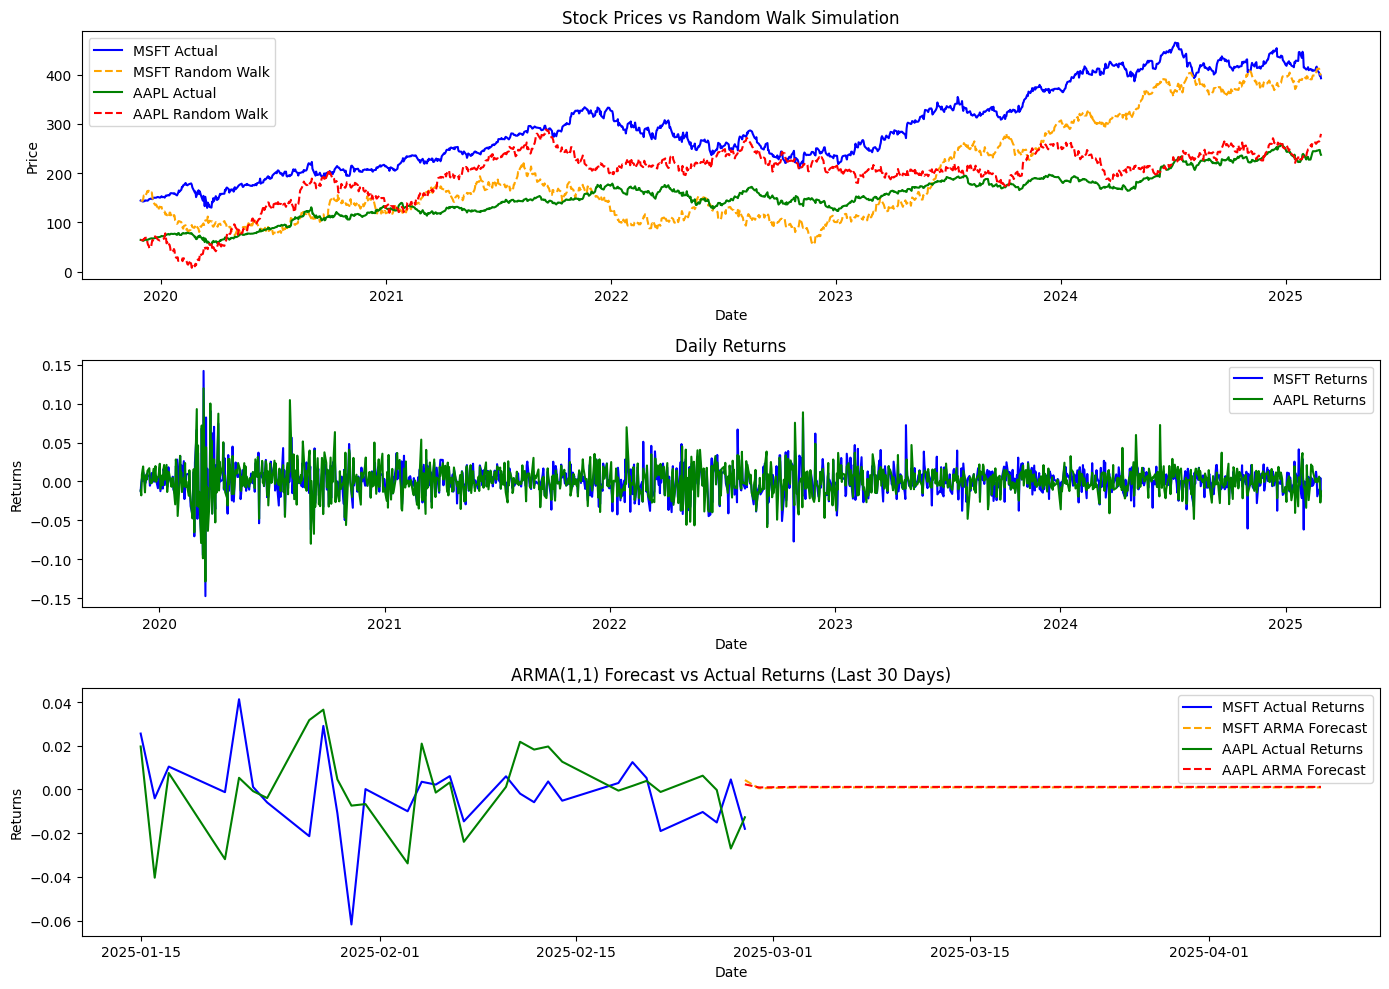

In [ ]:
# Install required libraries in Colab
!pip install yfinance statsmodels matplotlib pandas numpy

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

# Step 1: Fetch stock data for MSFT and AAPL from Nov 29, 2019
start_date = "2019-11-29"
end_date = "2025-02-28"

print("Fetching data for MSFT...")
msft_data = yf.download("MSFT", start=start_date, end=end_date)
print("Fetching data for AAPL...")
aapl_data = yf.download("AAPL", start=start_date, end=end_date)

# Extract 'Close' prices from MultiIndex
msft_prices = msft_data[("Close", "MSFT")].dropna()
aapl_prices = aapl_data[("Close", "AAPL")].dropna()

# Align indices for cointegration test
combined = pd.concat([msft_prices, aapl_prices], axis=1).dropna()
msft_prices = combined.iloc[:, 0]
aapl_prices = combined.iloc[:, 1]

# Step 2: Simulate a Random Walk
def random_walk_simulation(initial_price, steps, scale=1):
    random_steps = np.random.normal(loc=0, scale=scale, size=steps)
    random_steps[0] = 0
    return initial_price + np.cumsum(random_steps)

msft_rw = random_walk_simulation(msft_prices.iloc[0], len(msft_prices), scale=5)
aapl_rw = random_walk_simulation(aapl_prices.iloc[0], len(aapl_prices), scale=5)

# Step 3: Unit Root Test (ADF)
def unit_root_test(series, name):
    result = adfuller(series.dropna())
    print(f"\nUnit Root Test (ADF) for {name}:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:", {k: round(v, 4) for k, v in result[4].items()})
    if result[1] > 0.05:
        print(f"{name} likely has a unit root (non-stationary).")
    else:
        print(f"{name} does not have a unit root (stationary).")

msft_returns = msft_prices.pct_change().dropna()
aapl_returns = aapl_prices.pct_change().dropna()

unit_root_test(msft_prices, "MSFT Prices")
unit_root_test(aapl_prices, "AAPL Prices")
unit_root_test(msft_returns, "MSFT Returns")
unit_root_test(aapl_returns, "AAPL Returns")

# Step 4: Fit ARMA Model (ARMA(1,1))
def fit_arma(series, name):
    model = ARIMA(series, order=(1, 0, 1))
    fit = model.fit()
    print(f"\nARMA(1,1) Model Summary for {name}:")
    print(fit.summary().tables[1])
    return fit

msft_arma = fit_arma(msft_returns, "MSFT Returns")
aapl_arma = fit_arma(aapl_returns, "AAPL Returns")

# Step 5: Correlogram and Partial Correlogram of Residuals
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plot_acf(msft_arma.resid, ax=plt.gca(), title="ACF of MSFT ARMA Residuals")
plt.subplot(2, 2, 2)
plot_pacf(msft_arma.resid, ax=plt.gca(), title="PACF of MSFT ARMA Residuals")
plt.subplot(2, 2, 3)
plot_acf(aapl_arma.resid, ax=plt.gca(), title="ACF of AAPL ARMA Residuals")
plt.subplot(2, 2, 4)
plot_pacf(aapl_arma.resid, ax=plt.gca(), title="PACF of AAPL ARMA Residuals")
plt.tight_layout()
plt.show()

# Step 6: Cointegration Test (Engle-Granger)
print("\nCointegration Test (Engle-Granger) between MSFT and AAPL Prices:")
coint_result = coint(msft_prices, aapl_prices)
print(f"Cointegration Test Statistic: {coint_result[0]:.4f}")
print(f"p-value: {coint_result[1]:.4f}")
print("Critical Values:", {k: round(v, 4) for k, v in zip(['1%', '5%', '10%'], coint_result[2])})
if coint_result[1] < 0.05:
    print("Result: Reject the null hypothesis - MSFT and AAPL prices are cointegrated.")
else:
    print("Result: Fail to reject the null hypothesis - MSFT and AAPL prices are not cointegrated.")

# Step 7: Plotting Original Analyses
plt.figure(figsize=(14, 10))

# Random Walk vs Actual Prices
plt.subplot(3, 1, 1)
plt.plot(msft_prices.index, msft_prices, label="MSFT Actual", color="blue")
plt.plot(msft_prices.index, msft_rw, label="MSFT Random Walk", color="orange", linestyle="--")
plt.plot(aapl_prices.index, aapl_prices, label="AAPL Actual", color="green")
plt.plot(aapl_prices.index, aapl_rw, label="AAPL Random Walk", color="red", linestyle="--")
plt.title("Stock Prices vs Random Walk Simulation")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

# Returns
plt.subplot(3, 1, 2)
plt.plot(msft_returns.index, msft_returns, label="MSFT Returns", color="blue")
plt.plot(aapl_returns.index, aapl_returns, label="AAPL Returns", color="green")
plt.title("Daily Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()

# ARMA Forecasts (last 30 days)
msft_forecast = msft_arma.forecast(steps=30)
aapl_forecast = aapl_arma.forecast(steps=30)
forecast_index = pd.date_range(start=msft_returns.index[-1], periods=30, freq="B")

plt.subplot(3, 1, 3)
plt.plot(msft_returns.index[-30:], msft_returns[-30:], label="MSFT Actual Returns", color="blue")
plt.plot(forecast_index, msft_forecast, label="MSFT ARMA Forecast", color="orange", linestyle="--")
plt.plot(aapl_returns.index[-30:], aapl_returns[-30:], label="AAPL Actual Returns", color="green")
plt.plot(forecast_index, aapl_forecast, label="AAPL ARMA Forecast", color="red", linestyle="--")
plt.title("ARMA(1,1) Forecast vs Actual Returns (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()

plt.tight_layout()
plt.show()

Fetching data for AMZN...


[*********************100%***********************]  1 of 1 completed


Fetching data for NFLX...


[*********************100%***********************]  1 of 1 completed



Unit Root Test (ADF) for AMZN Prices:
ADF Statistic: -1.5861
p-value: 0.4905
Critical Values: {'1%': -3.4353, '5%': -2.8637, '10%': -2.5679}
AMZN Prices likely has a unit root (non-stationary).

Unit Root Test (ADF) for NFLX Prices:
ADF Statistic: 0.0486
p-value: 0.9624
Critical Values: {'1%': -3.4353, '5%': -2.8637, '10%': -2.5679}
NFLX Prices likely has a unit root (non-stationary).

Unit Root Test (ADF) for AMZN Returns:
ADF Statistic: -37.3810
p-value: 0.0000
Critical Values: {'1%': -3.4353, '5%': -2.8637, '10%': -2.5679}
AMZN Returns does not have a unit root (stationary).

Unit Root Test (ADF) for NFLX Returns:
ADF Statistic: -24.9039
p-value: 0.0000
Critical Values: {'1%': -3.4353, '5%': -2.8637, '10%': -2.5679}
NFLX Returns does not have a unit root (stationary).

ARMA(1,1) Model Summary for AMZN Returns:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0

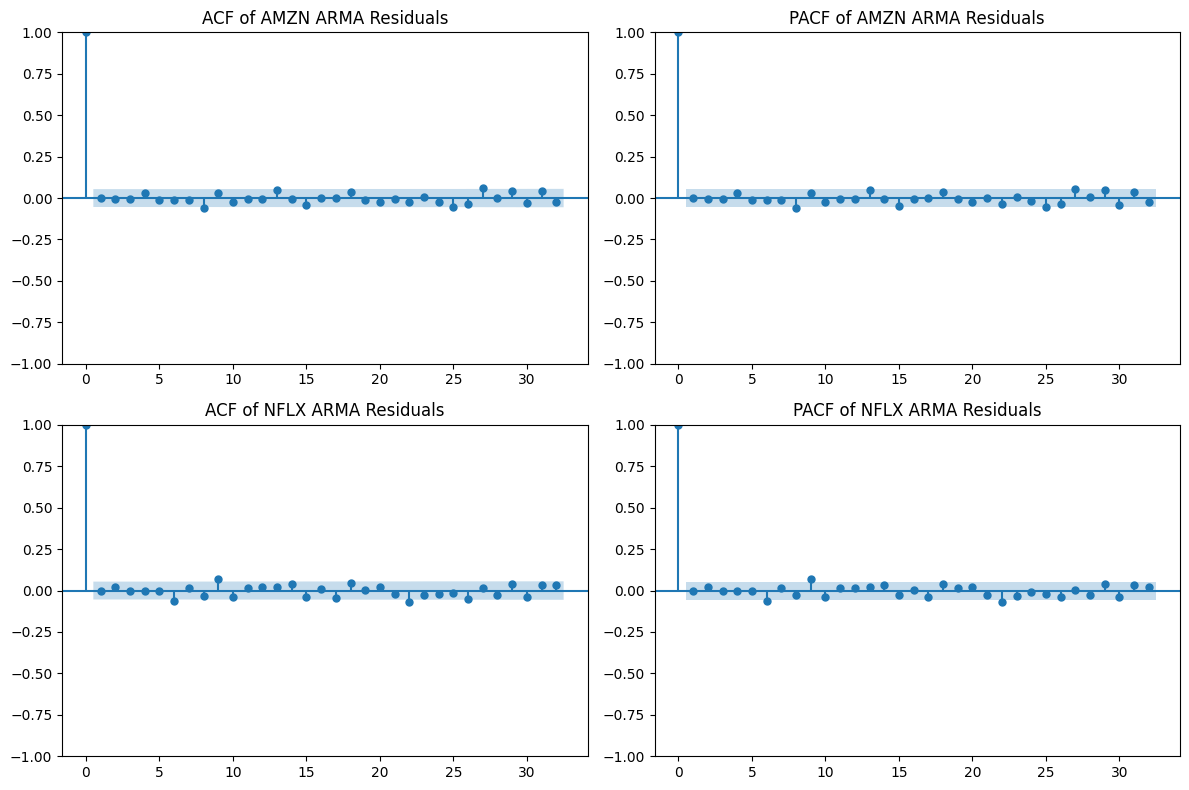


Cointegration Test (Engle-Granger) between AMZN and NFLX Prices:
Cointegration Test Statistic: -3.1706
p-value: 0.0750
Critical Values: {'1%': -3.9048, '5%': -3.3408, '10%': -3.0477}
Result: Fail to reject the null hypothesis - AMZN and NFLX prices are not cointegrated.


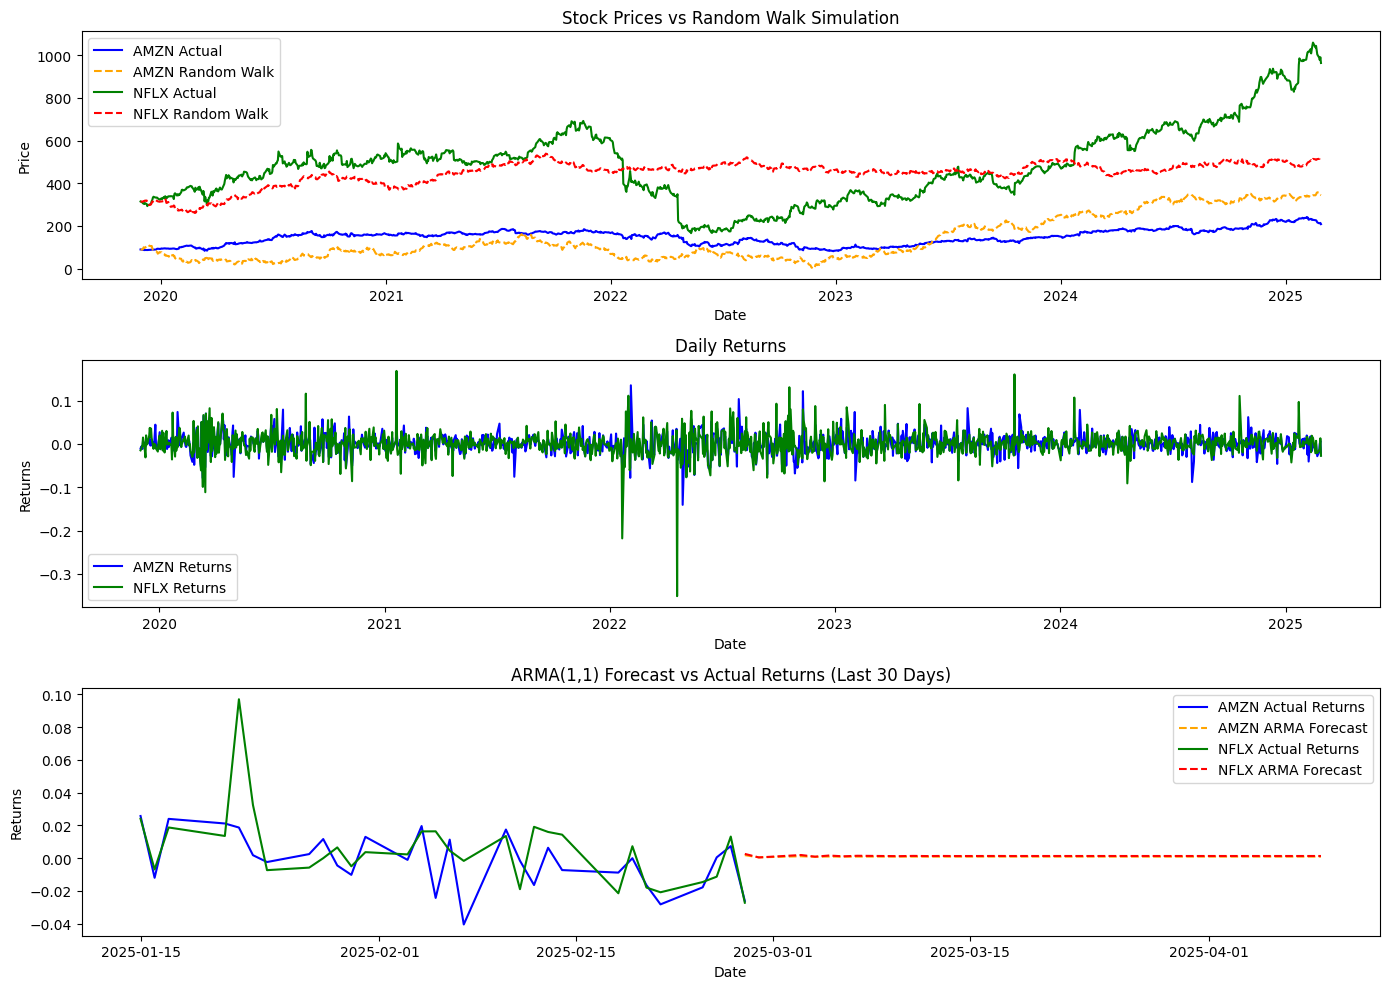

In [ ]:
# Install required libraries in Colab
!pip install yfinance statsmodels matplotlib pandas numpy

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

# Step 1: Fetch stock data for AMZN and NFLX from Nov 29, 2019
start_date = "2019-11-29"
end_date = "2025-02-28"

print("Fetching data for AMZN...")
amzn_data = yf.download("AMZN", start=start_date, end=end_date)
print("Fetching data for NFLX...")
nflx_data = yf.download("NFLX", start=start_date, end=end_date)

# Extract 'Close' prices from MultiIndex
amzn_prices = amzn_data[("Close", "AMZN")].dropna()
nflx_prices = nflx_data[("Close", "NFLX")].dropna()

# Align indices for cointegration test
combined = pd.concat([amzn_prices, nflx_prices], axis=1).dropna()
amzn_prices = combined.iloc[:, 0]
nflx_prices = combined.iloc[:, 1]

# Step 2: Simulate a Random Walk
def random_walk_simulation(initial_price, steps, scale=1):
    random_steps = np.random.normal(loc=0, scale=scale, size=steps)
    random_steps[0] = 0
    return initial_price + np.cumsum(random_steps)

amzn_rw = random_walk_simulation(amzn_prices.iloc[0], len(amzn_prices), scale=5)
nflx_rw = random_walk_simulation(nflx_prices.iloc[0], len(nflx_prices), scale=5)

# Step 3: Unit Root Test (ADF)
def unit_root_test(series, name):
    result = adfuller(series.dropna())
    print(f"\nUnit Root Test (ADF) for {name}:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:", {k: round(v, 4) for k, v in result[4].items()})
    if result[1] > 0.05:
        print(f"{name} likely has a unit root (non-stationary).")
    else:
        print(f"{name} does not have a unit root (stationary).")

amzn_returns = amzn_prices.pct_change().dropna()
nflx_returns = nflx_prices.pct_change().dropna()

unit_root_test(amzn_prices, "AMZN Prices")
unit_root_test(nflx_prices, "NFLX Prices")
unit_root_test(amzn_returns, "AMZN Returns")
unit_root_test(nflx_returns, "NFLX Returns")

# Step 4: Fit ARMA Model (ARMA(1,1))
def fit_arma(series, name):
    model = ARIMA(series, order=(1, 0, 1))
    fit = model.fit()
    print(f"\nARMA(1,1) Model Summary for {name}:")
    print(fit.summary().tables[1])
    return fit

amzn_arma = fit_arma(amzn_returns, "AMZN Returns")
nflx_arma = fit_arma(nflx_returns, "NFLX Returns")

# Step 5: Correlogram and Partial Correlogram of Residuals
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plot_acf(amzn_arma.resid, ax=plt.gca(), title="ACF of AMZN ARMA Residuals")
plt.subplot(2, 2, 2)
plot_pacf(amzn_arma.resid, ax=plt.gca(), title="PACF of AMZN ARMA Residuals")
plt.subplot(2, 2, 3)
plot_acf(nflx_arma.resid, ax=plt.gca(), title="ACF of NFLX ARMA Residuals")
plt.subplot(2, 2, 4)
plot_pacf(nflx_arma.resid, ax=plt.gca(), title="PACF of NFLX ARMA Residuals")
plt.tight_layout()
plt.show()

# Step 6: Cointegration Test (Engle-Granger)
print("\nCointegration Test (Engle-Granger) between AMZN and NFLX Prices:")
coint_result = coint(amzn_prices, nflx_prices)
print(f"Cointegration Test Statistic: {coint_result[0]:.4f}")
print(f"p-value: {coint_result[1]:.4f}")
print("Critical Values:", {k: round(v, 4) for k, v in zip(['1%', '5%', '10%'], coint_result[2])})
if coint_result[1] < 0.05:
    print("Result: Reject the null hypothesis - AMZN and NFLX prices are cointegrated.")
else:
    print("Result: Fail to reject the null hypothesis - AMZN and NFLX prices are not cointegrated.")

# Step 7: Plotting Original Analyses
plt.figure(figsize=(14, 10))

# Random Walk vs Actual Prices
plt.subplot(3, 1, 1)
plt.plot(amzn_prices.index, amzn_prices, label="AMZN Actual", color="blue")
plt.plot(amzn_prices.index, amzn_rw, label="AMZN Random Walk", color="orange", linestyle="--")
plt.plot(nflx_prices.index, nflx_prices, label="NFLX Actual", color="green")
plt.plot(nflx_prices.index, nflx_rw, label="NFLX Random Walk", color="red", linestyle="--")
plt.title("Stock Prices vs Random Walk Simulation")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

# Returns
plt.subplot(3, 1, 2)
plt.plot(amzn_returns.index, amzn_returns, label="AMZN Returns", color="blue")
plt.plot(nflx_returns.index, nflx_returns, label="NFLX Returns", color="green")
plt.title("Daily Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()

# ARMA Forecasts (last 30 days)
amzn_forecast = amzn_arma.forecast(steps=30)
nflx_forecast = nflx_arma.forecast(steps=30)
forecast_index = pd.date_range(start=amzn_returns.index[-1], periods=30, freq="B")

plt.subplot(3, 1, 3)
plt.plot(amzn_returns.index[-30:], amzn_returns[-30:], label="AMZN Actual Returns", color="blue")
plt.plot(forecast_index, amzn_forecast, label="AMZN ARMA Forecast", color="orange", linestyle="--")
plt.plot(nflx_returns.index[-30:], nflx_returns[-30:], label="NFLX Actual Returns", color="green")
plt.plot(forecast_index, nflx_forecast, label="NFLX ARMA Forecast", color="red", linestyle="--")
plt.title("ARMA(1,1) Forecast vs Actual Returns (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()

plt.tight_layout()
plt.show()

Fetching data for FB...


[*********************100%***********************]  1 of 1 completed


Fetching data for GOOG...


[*********************100%***********************]  1 of 1 completed



Unit Root Test (ADF) for FB Prices:
ADF Statistic: 0.5098
p-value: 0.9852
Critical Values: {'1%': -3.4353, '5%': -2.8637, '10%': -2.5679}
FB Prices likely has a unit root (non-stationary).

Unit Root Test (ADF) for GOOG Prices:
ADF Statistic: -1.3345
p-value: 0.6132
Critical Values: {'1%': -3.4353, '5%': -2.8637, '10%': -2.5679}
GOOG Prices likely has a unit root (non-stationary).

Unit Root Test (ADF) for FB Returns:
ADF Statistic: -38.0117
p-value: 0.0000
Critical Values: {'1%': -3.4353, '5%': -2.8637, '10%': -2.5679}
FB Returns does not have a unit root (stationary).

Unit Root Test (ADF) for GOOG Returns:
ADF Statistic: -11.5704
p-value: 0.0000
Critical Values: {'1%': -3.4354, '5%': -2.8638, '10%': -2.5679}
GOOG Returns does not have a unit root (stationary).

ARMA(1,1) Model Summary for FB Returns:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013     

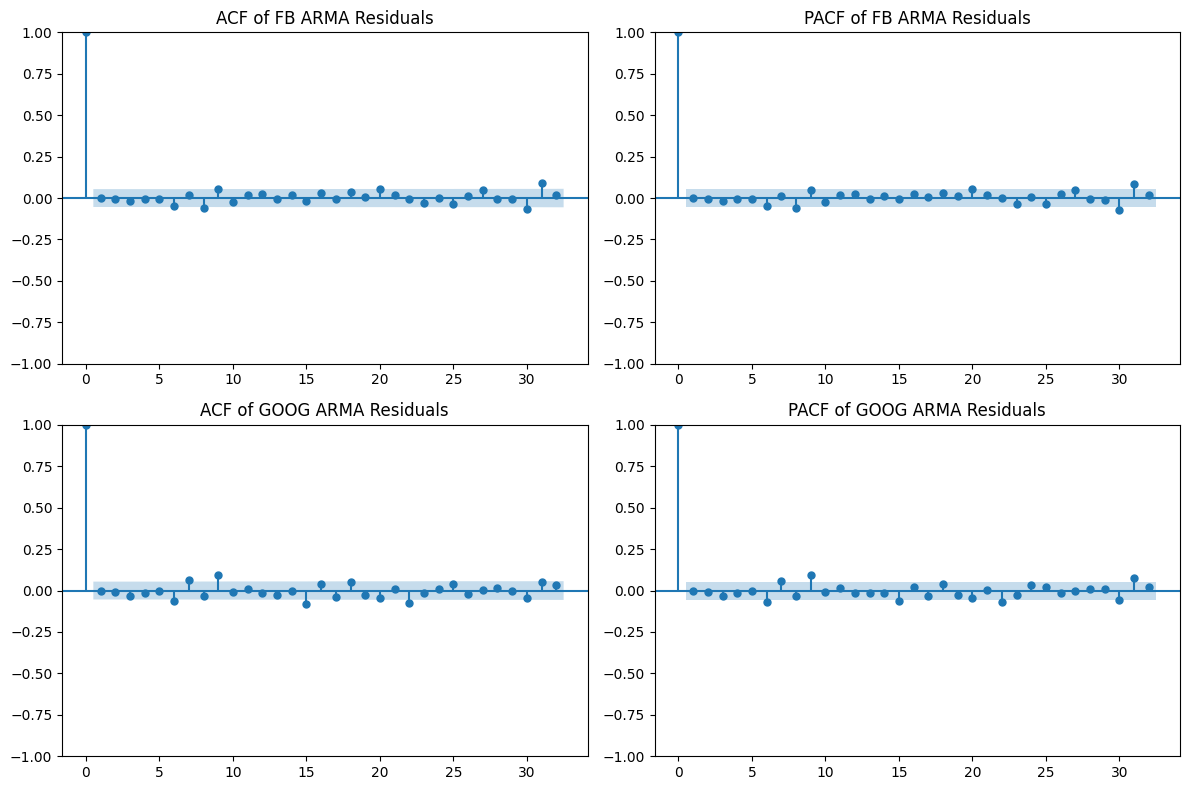


Cointegration Test (Engle-Granger) between FB and GOOG Prices:
Cointegration Test Statistic: -1.0789
p-value: 0.8868
Critical Values: {'1%': -3.9048, '5%': -3.3408, '10%': -3.0477}
Result: Fail to reject the null hypothesis - FB and GOOG prices are not cointegrated.


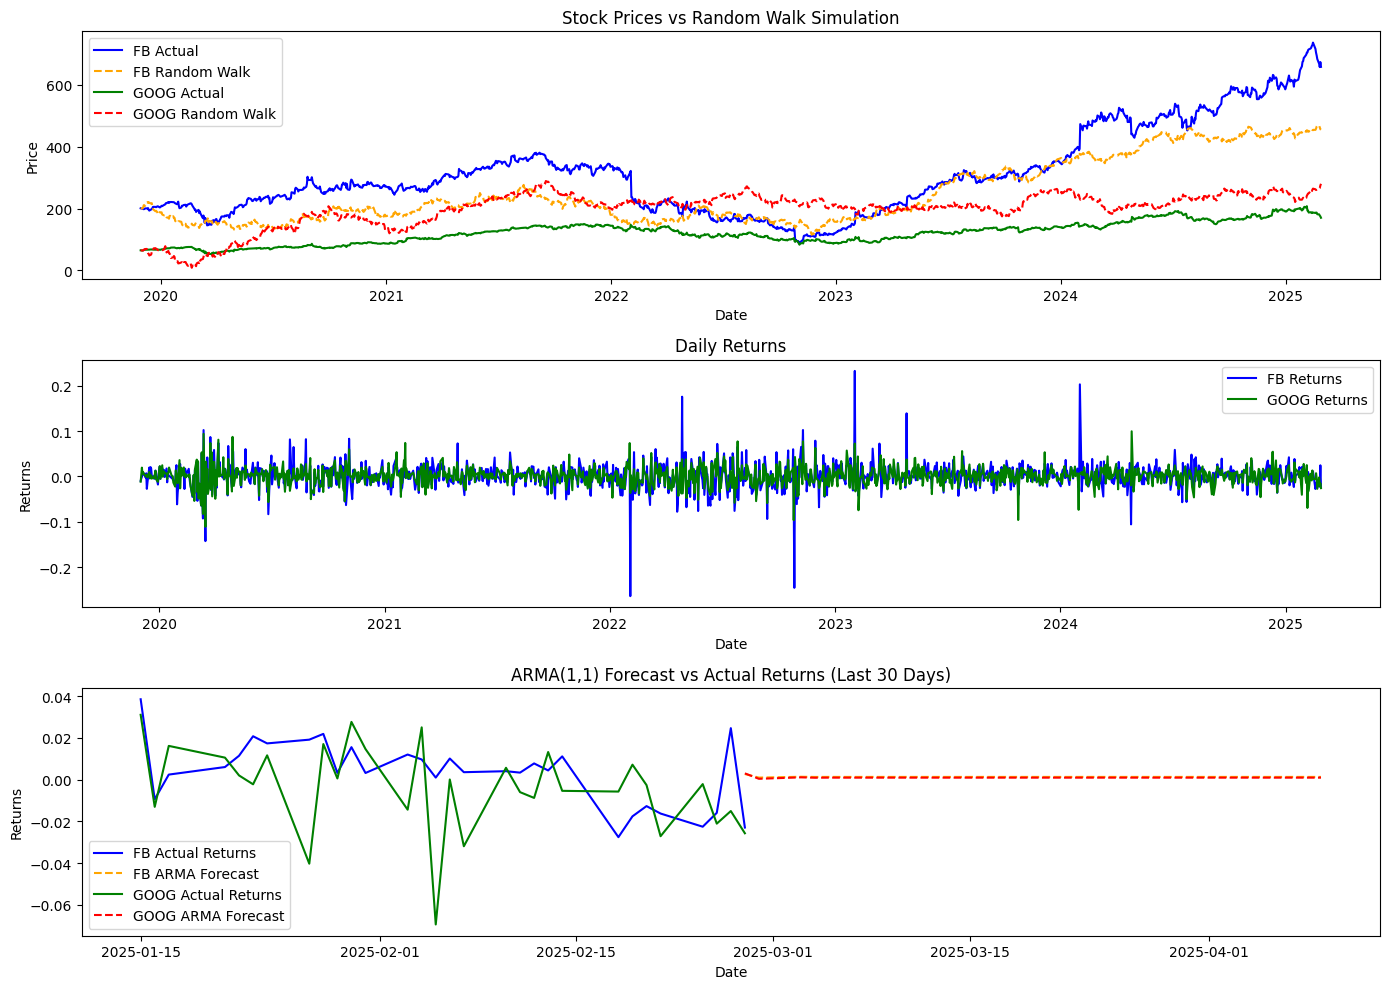

In [ ]:
# Install required libraries in Colab
!pip install yfinance statsmodels matplotlib pandas numpy

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

# Step 1: Fetch stock data for FB (Meta) and GOOG (Alphabet) from Nov 29, 2019
start_date = "2019-11-29"
end_date = "2025-02-28"

print("Fetching data for FB...")
fb_data = yf.download("META", start=start_date, end=end_date)
print("Fetching data for GOOG...")
goog_data = yf.download("GOOG", start=start_date, end=end_date)

# Extract 'Close' prices from DataFrame
fb_prices = fb_data["Close"].dropna()
goog_prices = goog_data["Close"].dropna()

# Align indices for cointegration test
combined = pd.concat([fb_prices, goog_prices], axis=1).dropna()
fb_prices = combined.iloc[:, 0]
goog_prices = combined.iloc[:, 1]

# Step 2: Simulate a Random Walk
def random_walk_simulation(initial_price, steps, scale=1):
    random_steps = np.random.normal(loc=0, scale=scale, size=steps)
    random_steps[0] = 0
    return initial_price + np.cumsum(random_steps)

fb_rw = random_walk_simulation(fb_prices.iloc[0], len(fb_prices), scale=5)
goog_rw = random_walk_simulation(goog_prices.iloc[0], len(goog_prices), scale=5)

# Step 3: Unit Root Test (ADF)
def unit_root_test(series, name):
    result = adfuller(series.dropna())
    print(f"\nUnit Root Test (ADF) for {name}:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:", {k: round(v, 4) for k, v in result[4].items()})
    if result[1] > 0.05:
        print(f"{name} likely has a unit root (non-stationary).")
    else:
        print(f"{name} does not have a unit root (stationary).")

fb_returns = fb_prices.pct_change().dropna()
goog_returns = goog_prices.pct_change().dropna()

unit_root_test(fb_prices, "FB Prices")
unit_root_test(goog_prices, "GOOG Prices")
unit_root_test(fb_returns, "FB Returns")
unit_root_test(goog_returns, "GOOG Returns")

# Step 4: Fit ARMA Model (ARMA(1,1))
def fit_arma(series, name):
    model = ARIMA(series, order=(1, 0, 1))
    fit = model.fit()
    print(f"\nARMA(1,1) Model Summary for {name}:")
    print(fit.summary().tables[1])
    return fit

fb_arma = fit_arma(fb_returns, "FB Returns")
goog_arma = fit_arma(goog_returns, "GOOG Returns")

# Step 5: Correlogram and Partial Correlogram of Residuals
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plot_acf(fb_arma.resid, ax=plt.gca(), title="ACF of FB ARMA Residuals")
plt.subplot(2, 2, 2)
plot_pacf(fb_arma.resid, ax=plt.gca(), title="PACF of FB ARMA Residuals")
plt.subplot(2, 2, 3)
plot_acf(goog_arma.resid, ax=plt.gca(), title="ACF of GOOG ARMA Residuals")
plt.subplot(2, 2, 4)
plot_pacf(goog_arma.resid, ax=plt.gca(), title="PACF of GOOG ARMA Residuals")
plt.tight_layout()
plt.show()

# Step 6: Cointegration Test (Engle-Granger)
print("\nCointegration Test (Engle-Granger) between FB and GOOG Prices:")
coint_result = coint(fb_prices, goog_prices)
print(f"Cointegration Test Statistic: {coint_result[0]:.4f}")
print(f"p-value: {coint_result[1]:.4f}")
print("Critical Values:", {k: round(v, 4) for k, v in zip(['1%', '5%', '10%'], coint_result[2])})
if coint_result[1] < 0.05:
    print("Result: Reject the null hypothesis - FB and GOOG prices are cointegrated.")
else:
    print("Result: Fail to reject the null hypothesis - FB and GOOG prices are not cointegrated.")

# Step 7: Plotting Original Analyses
plt.figure(figsize=(14, 10))

# Random Walk vs Actual Prices
plt.subplot(3, 1, 1)
plt.plot(fb_prices.index, fb_prices, label="FB Actual", color="blue")
plt.plot(fb_prices.index, fb_rw, label="FB Random Walk", color="orange", linestyle="--")
plt.plot(goog_prices.index, goog_prices, label="GOOG Actual", color="green")
plt.plot(goog_prices.index, goog_rw, label="GOOG Random Walk", color="red", linestyle="--")
plt.title("Stock Prices vs Random Walk Simulation")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

# Returns
plt.subplot(3, 1, 2)
plt.plot(fb_returns.index, fb_returns, label="FB Returns", color="blue")
plt.plot(goog_returns.index, goog_returns, label="GOOG Returns", color="green")
plt.title("Daily Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()

# ARMA Forecasts (last 30 days)
fb_forecast = fb_arma.forecast(steps=30)
goog_forecast = goog_arma.forecast(steps=30)
forecast_index = pd.date_range(start=fb_returns.index[-1], periods=30, freq="B")

plt.subplot(3, 1, 3)
plt.plot(fb_returns.index[-30:], fb_returns[-30:], label="FB Actual Returns", color="blue")
plt.plot(forecast_index, fb_forecast, label="FB ARMA Forecast", color="orange", linestyle="--")
plt.plot(goog_returns.index[-30:], goog_returns[-30:], label="GOOG Actual Returns", color="green")
plt.plot(forecast_index, goog_forecast, label="GOOG ARMA Forecast", color="red", linestyle="--")
plt.title("ARMA(1,1) Forecast vs Actual Returns (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()

plt.tight_layout()
plt.show()

SyntaxError: invalid decimal literal (<ipython-input-11-ac279253d6ab>, line 19)